<a href="https://colab.research.google.com/github/LakshaySharma-2003/PROJECTS/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tweet Emotion Recognition : Natural Language Processing with TensorFlo**w
Dataset: 

# Setup and Imports

1.   installing hugging face's nlp package
2.   import libraries



In [80]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
  epochs_trained=len(h.history('loss'))
  plt.figure(figsize=(16,6))

  plt.subplot(1,2,1)
  plt.plot(range(0,epochs_trained),h.history.get('accuracy'),label='Training')
  plt.plot(range(0,epochs_trained),h.history.get('val_accuracy'),label='Validation')
  plt.ylim([0.,1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(range(0,epochs_trained),h.history.get('accuracy'),label='Training')
  plt.plot(range(0,epochs_trained),h.history.get('val_accuracy'),label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def show_confusion_matrix(y_true,y_pred,classes):
  from sklearn.metrics import confusion_matrix

  cm=confusion_matrix(y_true,y_pred,normalize='true')

  plt.figure(figsize=(8,8))
  sp=plt.subplot(1,1,1)
  ctx=plt.matshow(cm)
  plt.xticks(list(range(0,6)),labels=classes)
  plt.yticks(list(range(0,6)),labels=classes)
  plt.colorbar(ctx)
  plt.show()

print('Using Tensorflow version',tf.__version__)

Using Tensorflow version 2.9.2


# Importing Data


1.   Importing the Tweet Emotion data
2.   Creating Train, validation and test sets
3.   Extracting tweets and labels from the examples



In [82]:
dataset=nlp.load_dataset('emotion')

In [83]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [84]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [85]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

tweet,label=get_tweet(train)

In [86]:
tweet[0],label[0]

('i didnt feel humiliated', 'sadness')

# Tokenizer


*   Tokenzing the tweets



In [87]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=10000 , oov_token='<UNK>')
tokenizer.fit_on_texts(tweet)
tokenizer.texts_to_sequences([tweet[0]])

[[2, 139, 3, 679]]

# Padding and Truncating Sequences
1. Checking length of the tweets
2. Creating padded sequences

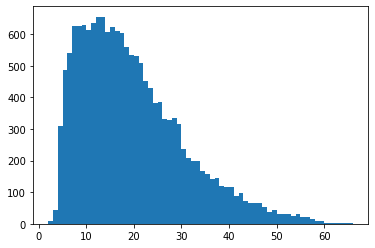

In [88]:
lengths=[len(t.split(' ')) for t in tweet]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [89]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post',padding='post',maxlen=maxlen)
  return padded
  
padded_train_seq=get_sequences(tokenizer,tweet)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

# Preparing the labels
1. creating classes to index and index to classes dictionaries
2. converting text labels to numeric labels

In [90]:
classes = set(label)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

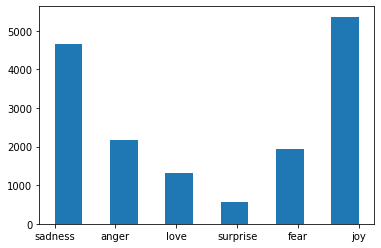

In [91]:
plt.hist(label,bins=11)
plt.show()

In [92]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((x,y)for x,y in class_to_index.items())
class_to_index

{'sadness': 0, 'anger': 1, 'fear': 2, 'love': 3, 'surprise': 4, 'joy': 5}

In [93]:
index_to_class

{'sadness': 0, 'anger': 1, 'fear': 2, 'love': 3, 'surprise': 4, 'joy': 5}

In [94]:
names_to_ids=lambda label:np.array([class_to_index.get(x) for x in label])

In [95]:
train_labels=names_to_ids(label)
train_labels[0]

0

#Creating the Model
1. Creating the model
2. compiling the model

In [101]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [102]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


# Training the Model
1. Preparing a validation set
2. Training the Model

In [103]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)

In [104]:
val_tweets[0],val_labels[0]  

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [105]:
h= model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 15s 14ms/step - loss: 1.3092 - accuracy: 0.4834 - val_loss: 0.8609 - val_accuracy: 0.6675
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.5789 - accuracy: 0.7831 - val_loss: 0.5987 - val_accuracy: 0.7765
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3402 - accuracy: 0.8856 - val_loss: 0.4524 - val_accuracy: 0.8630
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2356 - accuracy: 0.9263 - val_loss: 0.4654 - val_accuracy: 0.8590
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1696 - accuracy: 0.9493 - val_loss: 0.3968 - val_accuracy: 0.8800
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1329 - accuracy: 0.9601 - val_loss: 0.4198 - val_accuracy: 0.8830
Epoch 7/20
500/500 [==============================] - 6s 11ms/step - loss: 0.1148 - accuracy: 0.9646 - val_loss: 0.4101 - val_accuracy: 0.884